In [15]:
# Import required libaries 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import wget 
import os 
import pandas as pd
import numpy as np 

# Data Extraction

In [16]:
# Create dataframe from CSV 

imagery_df = pd.read_csv('basic_good_image_set.csv')
imagery_df = imagery_df.fillna('None')
print(imagery_df.dtypes)
print(imagery_df)

Year                       int64
Month                      int64
Day                        int64
Cloudiness                object
Greenness                 object
Estimated Usability       object
Area Estimate              int64
Top Right Latitude       float64
Top Right Longitude      float64
Bottom Left Latitude     float64
Bottom Left Longitude    float64
Image Filename            object
URL                       object
dtype: object
    Year  Month  Day Cloudiness    Greenness Estimated Usability  \
0   2024      7    8       None         High                High   
1   2023      7   23       None  Medium-High         Medium-High   
2   2022      7   24       None         High                High   
3   2021      7    1       None  Medium-High         Medium-High   
4   2020      7   27       None         High                High   
5   2019      7   23       None         High                High   
6   2018      7   16       None  Medium-High         Medium-High   
7   2017     

In [17]:
# Download files, should ONLY download if they are not already in to directory 
# Source of directory read technique: https://www.geeksforgeeks.org/python/python-list-files-in-a-directory/
# If we need to do any os related things you can grab os from: https://www.google.com/search?q=get+os+version+python&sca_esv=7a3339a54e4f1566&ei=Y0EWaevMCJaA0PEPhtjtmQw&ved=0ahUKEwiriuy5_e-QAxUWADQIHQZsO8MQ4dUDCBE&uact=5&oq=get+os+version+python&gs_lp=Egxnd3Mtd2l6LXNlcnAiFWdldCBvcyB2ZXJzaW9uIHB5dGhvbjIFEAAYgAQyBhAAGBYYHjIGEAAYFhgeMggQABiABBiiBDIFEAAY7wUyBRAAGO8FSLZXUMYPWKBWcAN4AZABAJgBjAGgAcYOqgEEMTkuMrgBA8gBAPgBAZgCGKACtA_CAgoQABiwAxjWBBhHwgILEAAYgAQYkQIYigXCAhAQABiABBixAxhDGIMBGIoFwgIWEC4YgAQYsQMY0QMYQxiDARjHARiKBcICEBAuGIAEGNEDGEMYxwEYigXCAgoQABiABBhDGIoFwgIKEC4YgAQYQxiKBcICCxAuGIAEGMcBGK8BwgIOEC4YgAQYsQMYgwEY1ALCAg4QABiABBixAxiDARiKBcICBRAuGIAEwgIIEC4YgAQYsQPCAgQQABgDwgIOEC4YgAQYsQMY0QMYxwHCAg0QABiABBixAxhDGIoFwgINEC4YgAQYsQMYQxiKBcICCxAuGIAEGLEDGNQCwgILEAAYgAQYsQMYgwHCAggQABiABBixA8ICCxAuGIAEGLEDGIMBwgIcEC4YgAQYsQMYQxiKBRiXBRjcBBjeBBjgBNgBAcICCxAAGIAEGIYDGIoFmAMAiAYBkAYIugYGCAEQARgUkgcEMTguNqAH6aABsgcEMTUuNrgHqQ_CBwcwLjExLjEzyAdS&sclient=gws-wiz-serp

# Select the path you want to evaluate, the only dataset currently is the basic known good image set 
path = './city_images/raw/basic_good_image_set' 

dir_list = os.listdir(path)

for i in range(len(imagery_df)):
    image_fn = imagery_df['Image Filename'][i]
    if not image_fn in dir_list:
        print('Image not already in folder, downloading...')
        image = wget.download(imagery_df['URL'][i],path+image_fn)
    else:
        print('Image already in image folder')

Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder
Image already in image folder


# Image Cleaning

In [18]:
# Only select images that do not have clouds and are in summer months, this will be more complicated if we don't manually label the cloudy data 
print(f'Total length of precleaned dataset: {len(imagery_df)}') 
cleaned_df = imagery_df.query("Month == 7 & Cloudiness.eq('None') & Greenness.eq('High')")
print(f'Total length of cleaned dataset: {len(cleaned_df)}')

for im_fn in cleaned_df['Image Filename']:
    image = cv2.imread('./city_images/raw/basic_good_image_set/'+im_fn)
    cv2.imwrite('./city_images/cleaned/basic_good_image_set/'+im_fn,image)

Total length of precleaned dataset: 24
Total length of cleaned dataset: 14


# Image Processing

In [19]:
# Improved image processing with boundaries to exclude surrounding towns
# Also tracks urban growth over time - city only grows, never shrinks

# HSV thresholds for green vegetation
lower_green = np.array([40, 40, 0]) 
upper_green = np.array([85, 255, 255]) 

lower_grey = 0  
upper_grey = 255

# Define outer boundary to exclude Airdrie, Okotoks, etc
outer_boundary = [
    [0.14, 0.30],  [0.25, 0.28],  [0.40, 0.23],  [0.60, 0.22],  [0.75, 0.23],
    [0.77, 0.38],  [0.92, 0.40],  [0.92, 0.60],  [0.88, 0.80],  [0.70, 0.87],
    [0.50, 0.90],  [0.30, 0.85],  [0.25, 0.70],  [0.10, 0.60],  [0.06, 0.40]
]

# Inner boundary is the city center from 2001 (always urban)
inner_boundary = [
    [0.14, 0.39],  [0.25, 0.39],  [0.40, 0.37],  [0.50, 0.37],  [0.58, 0.45],
    [0.65, 0.39],  [0.65, 0.41],  [0.65, 0.60],  [0.60, 0.80],  [0.55, 0.83],
    [0.50, 0.82],  [0.41, 0.79],  [0.31, 0.62],  [0.24, 0.60],  [0.14, 0.40]
]

print(f"Processing {len(cleaned_df)} images...")

# Need to sort by year first
df_sorted = cleaned_df.sort_values('Year')

# This stores what was urban in previous years
prev_urban = None
images_processed = []

for idx, row in df_sorted.iterrows():
    im_fn = row['Image Filename']
    year = row['Year']
    
    # Load the image
    img = cv2.imread('./city_images/cleaned/basic_good_image_set/' + im_fn)
    h, w = img.shape[:2]
    
    # Make outer boundary mask
    outer_pts = np.array([[int(w*x), int(h*y)] for x, y in outer_boundary], dtype=np.int32)
    outer = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(outer, [outer_pts], 255)
    
    # Make inner boundary mask
    inner_pts = np.array([[int(w*x), int(h*y)] for x, y in inner_boundary], dtype=np.int32)
    inner = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(inner, [inner_pts], 255)
    
    # Area between inner and outer boundaries
    between = cv2.subtract(outer, inner)
    
    # Find green areas and invert
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    green = cv2.inRange(hsv, lower_green, upper_green)
    not_green = cv2.bitwise_not(green)
    
    # In between region, only keep non-green parts
    between_urban = cv2.bitwise_and(between, not_green)
    
    # Combine inner + between urban areas
    this_year = cv2.bitwise_or(inner, between_urban)
    
    # Add previous years urban areas (cumulative growth)
    if prev_urban is not None:
        result = cv2.bitwise_or(prev_urban, this_year)
    else:
        result = this_year
    
    prev_urban = result.copy()
    
    # Save result
    cv2.imwrite('./city_images/processed/basic_good_image_set/' + im_fn.split('.')[0] + '.bmp', result)
    images_processed.append(result)
    
    pixels = cv2.countNonZero(result)
    print(f"{year}: {pixels:,} pixels")

print(f"\nDone! Processed {len(images_processed)} images") 


Processing 14 images...
2001: 14,978 pixels
2003: 19,102 pixels
2005: 20,064 pixels
2006: 22,174 pixels
2007: 24,494 pixels
2008: 24,749 pixels
2009: 26,397 pixels
2011: 27,331 pixels
2015: 28,416 pixels
2016: 28,476 pixels
2019: 29,057 pixels
2020: 29,496 pixels
2022: 30,233 pixels
2024: 30,454 pixels

Done! Processed 14 images


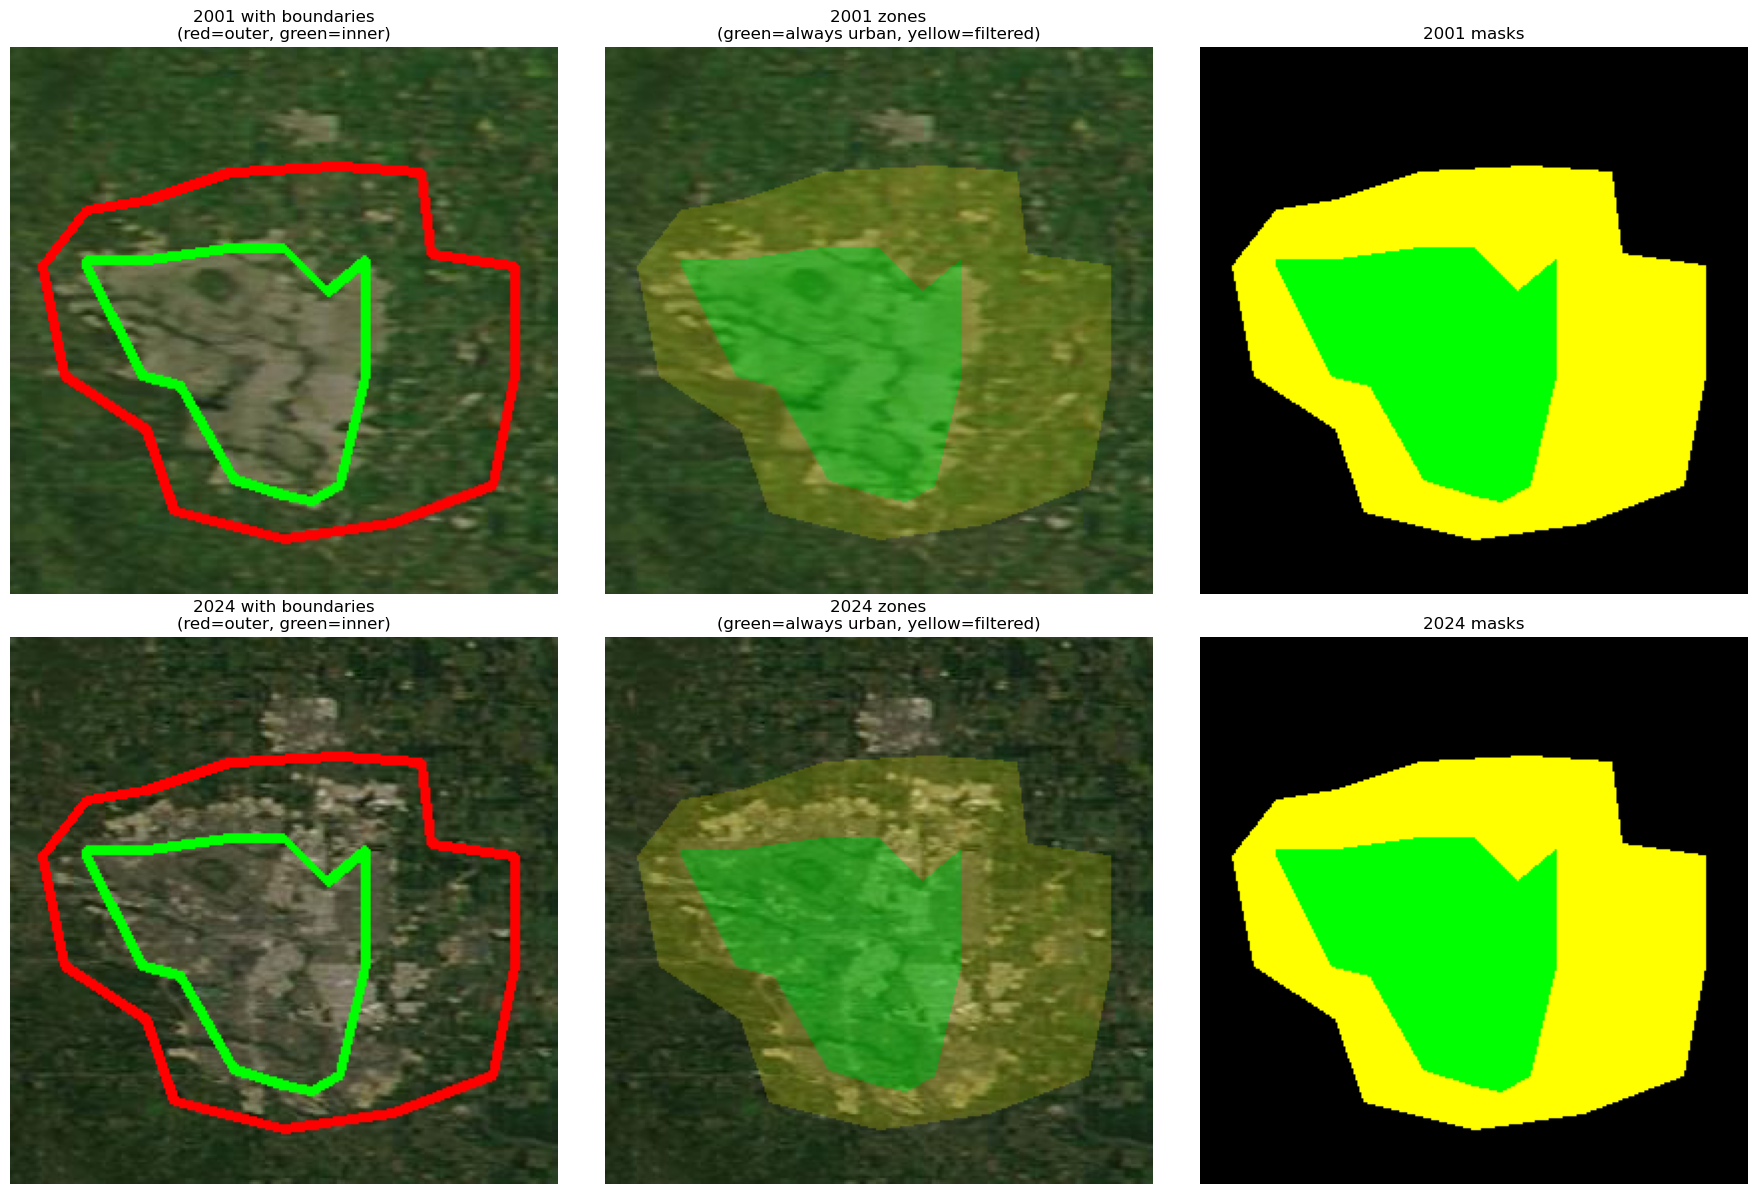

In [26]:
# Optional: Check boundaries on 2001 and 2024 images

# Get 2001 and 2024 images
year_2001 = cleaned_df[cleaned_df['Year'] == 2001].iloc[0]
year_2024 = cleaned_df[cleaned_df['Year'] == 2024].iloc[0]

test_years = [(2001, year_2001), (2024, year_2024)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (year, row) in enumerate(test_years):
    # Load image
    img = cv2.imread('./city_images/cleaned/basic_good_image_set/' + row['Image Filename'])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Make boundaries
    outer_pts = np.array([[int(w*x), int(h*y)] for x, y in outer_boundary], dtype=np.int32)
    inner_pts = np.array([[int(w*x), int(h*y)] for x, y in inner_boundary], dtype=np.int32)
    
    outer = np.zeros((h, w), dtype=np.uint8)
    inner = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(outer, [outer_pts], 255)
    cv2.fillPoly(inner, [inner_pts], 255)
    
    # Image with boundary lines
    img_lines = img_rgb.copy()
    cv2.polylines(img_lines, [outer_pts], True, (255, 0, 0), 3)
    cv2.polylines(img_lines, [inner_pts], True, (0, 255, 0), 3)
    axes[idx][0].imshow(img_lines)
    axes[idx][0].set_title(f'{year} with boundaries\n(red=outer, green=inner)')
    axes[idx][0].axis('off')
    
    # Colored overlay
    overlay = img_rgb.copy()
    overlay[inner == 255] = overlay[inner == 255] * 0.6 + np.array([0, 255, 0]) * 0.4
    between = cv2.subtract(outer, inner)
    overlay[between == 255] = overlay[between == 255] * 0.8 + np.array([255, 255, 0]) * 0.2
    axes[idx][1].imshow(overlay)
    axes[idx][1].set_title(f'{year} zones\n(green=always urban, yellow=filtered)')
    axes[idx][1].axis('off')
    
    # Just masks
    masks = np.zeros((h, w, 3), dtype=np.uint8)
    masks[inner == 255] = [0, 255, 0]
    masks[between == 255] = [255, 255, 0]
    axes[idx][2].imshow(masks)
    axes[idx][2].set_title(f'{year} masks')
    axes[idx][2].axis('off')

plt.tight_layout()
plt.show()





# Image Analysis

In [21]:
# Determine distances of image manually 
distance_width = 42 # km - determined from calculator: https://www.nhc.noaa.gov/gccalc.shtml
distance_height = 67 # km - determined from calculator: " 

area_per_year = [] 

for im_fn in cleaned_df['Image Filename']:
    image = cv2.imread('./city_images/processed/basic_good_image_set/'+im_fn.split('.')[0]+'.bmp',cv2.IMREAD_GRAYSCALE)

    # Calculate sq km per pixel 
    pixel_width = 275 
    pixel_height = 275
    sqkmpp = (distance_width*distance_height)/(pixel_height*pixel_width)

    # Calculate area estimate 
    area_estimate = cv2.countNonZero(image)*sqkmpp
    area_per_year.append(area_estimate)

print(area_per_year)

[1133.190823140496, 1124.9674314049587, 1097.5437223140495, 1081.2085685950412, 1059.5896066115702, 1057.357011570248, 1016.9842512396694, 982.230188429752, 920.9082446280992, 911.4197157024794, 825.0927074380165, 746.5797818181818, 710.7838413223141, 557.3301421487603]


In [22]:

print(len(area_per_year))

14


In [23]:
years = list(cleaned_df['Year'])
manual_area = list(cleaned_df['Area Estimate'])




# Graph Visualization

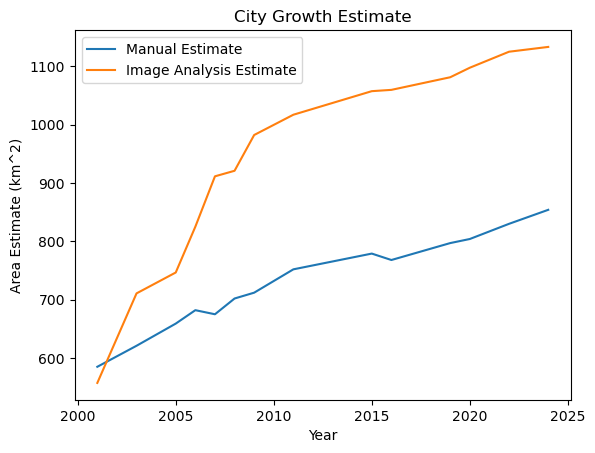

In [24]:
plt.plot(years,manual_area,label='Manual Estimate')
plt.plot(years,area_per_year,label='Image Analysis Estimate')
plt.xlabel('Year')
plt.ylabel('Area Estimate (km^2)')
plt.title('City Growth Estimate')
plt.legend()